In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import pandas as pd

In [3]:
df = pd.read_csv("./testset.csv")

In [4]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [5]:
df[' _tempm'].fillna(df[' _tempm'].mean(), inplace=True)

In [6]:
df[' _tempm'].isna().sum()

0

In [7]:
def get_year(x):
  return x[0:4]

In [8]:
def get_month(x):
  return x[5:7]

In [9]:
df['year'] = df['datetime_utc'].apply(lambda x: get_year(str(x)))
df['month'] = df['datetime_utc'].apply(lambda x: get_month(str(x)))

In [10]:
data = pd.DataFrame(list(df[' _tempm']), index=df['datetime_utc'], columns=['temp'])

In [11]:
data

,temp
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0
...,...
2017-04-24 06:00:00,34.0
2017-04-24 09:00:00,38.0
2017-04-24 12:00:00,36.0


In [12]:
data=data.values
data=data.astype('float32')

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
sc=scaler.fit_transform(data)

In [14]:
timestep=48
X=[]
Y=[]

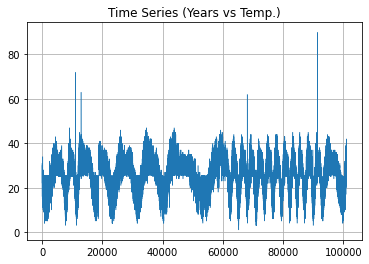

In [15]:
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.savefig("pic.png")
plt.show()

In [16]:
for i in range(len(sc)-(timestep)):
  X.append(sc[i:i+timestep])
  Y.append(sc[i+timestep])

In [17]:
import numpy as np
X=np.asanyarray(X)
Y=np.asanyarray(Y)

In [18]:
k = 35000
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0],  Xtrain.shape[1],1))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1],1))

In [19]:
X.shape

(100942, 48, 1)

In [20]:
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 7)
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(48,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [21]:
history = model.fit(Xtrain,Ytrain,epochs=10,verbose=1,batch_size=32) 

Epoch 1/10
1094/1094 [==============================] - 497s 455ms/step - loss: 0.0012
Epoch 2/10
1094/1094 [==============================] - 497s 455ms/step - loss: 6.2727e-04
Epoch 3/10
1094/1094 [==============================] - 490s 448ms/step - loss: 6.0915e-04
Epoch 4/10
1094/1094 [==============================] - 489s 447ms/step - loss: 5.7771e-04
Epoch 5/10
1094/1094 [==============================] - 481s 440ms/step - loss: 5.6157e-04
Epoch 6/10
1094/1094 [==============================] - 480s 438ms/step - loss: 5.5055e-04
Epoch 7/10
1094/1094 [==============================] - 486s 444ms/step - loss: 5.3714e-04
Epoch 8/10
1094/1094 [==============================] - 485s 443ms/step - loss: 5.3483e-04
Epoch 9/10
1080/1094 [============================>.] - ETA: 6s - loss: 5.4365e-04

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest = np.asanyarray(Ytest)  
Ytest = Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

In [ ]:
from sklearn.metrics import mean_squared_error
y_index  = data.index
Ytrain_index = y_index[:k]    
Ytest_index = y_index[k:-48]

preds = pd.DataFrame(preds)
pred= preds.rename(index=str, columns={0: 'Pred_Temp'})

Ytest = pd.DataFrame(Ytest)

Ytest= Ytest.rename(index=str, columns={0: 'Actual_Temp'})
pred_actual = pred.join(Ytest)
pred_actual.index = Ytest_index


mean_squared_error(Ytest,preds)

In [ ]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Ytesting, pred)

9.121115

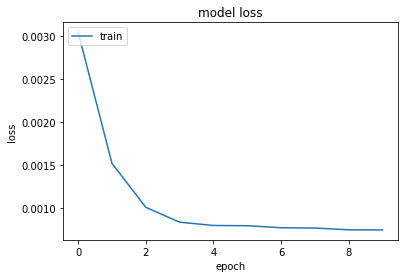

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()